In [1]:
%load_ext autoreload
%autoreload 2

%cd /home/rmhl/repos/stargraph

[Errno 2] No such file or directory: '/home/rmhl/repos/stargraph'
/Users/perper/Documents/active-learning/mnistvae


In [1]:
%load_ext autoreload
%autoreload 2
%cd /Users/perper/Documents/active-learning/mnistvae

/Users/perper/Documents/active-learning/mnistvae


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"


In [3]:
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "5"
os.environ["TF_USE_NVLINK_FOR_PARALLEL_COMPILATION"] = "0"
p = os.environ["PATH"]
os.environ["PATH"] = f"{p}:/usr/local/cuda/bin"

from functools import partial
import jax
import jax.numpy as jnp
from jaxtyping import PyTree
from torch.utils.data import DataLoader
import equinox as eqx
import matplotlib.pyplot as plt
import distrax as dsx
import optax
import seaborn as sns

sns.set()

#from data import SpokenMNISTMultimodalDataset
from model.image_vae import ImageVAE, ImageVAEOutput
from model.loss import ELBOLossOutput, get_evidence_lower_bound
from model.visualization import visualize_reconstructions


BATCH_SIZE = 16

In [4]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)


cpu


In [84]:
import tensorflow_datasets as tfds

In [70]:
from typing import Iterator, Mapping, NamedTuple, Sequence, Tuple
import numpy as np

In [71]:
PRNGKey = jnp.ndarray
Batch = Mapping[str, np.ndarray]
batch_size = BATCH_SIZE
random_seed = 42

MNIST_IMAGE_SHAPE: Sequence[int] = (28, 28, 1)


def load_dataset(split: str, batch_size: int) -> Iterator[Batch]:
    ds = tfds.load(
        "binarized_mnist",
        split=split,
        shuffle_files=True,
        read_config=tfds.ReadConfig(shuffle_seed=random_seed),
    )
    ds = ds.shuffle(buffer_size=10 * batch_size, seed=random_seed)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=5)
    ds = ds.repeat()
    return iter(tfds.as_numpy(ds))


In [72]:
train_dataloader = load_dataset(tfds.Split.TRAIN, batch_size)
test_dataloader = load_dataset(tfds.Split.TEST, batch_size)

2023-11-20 10:38:09.356830: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


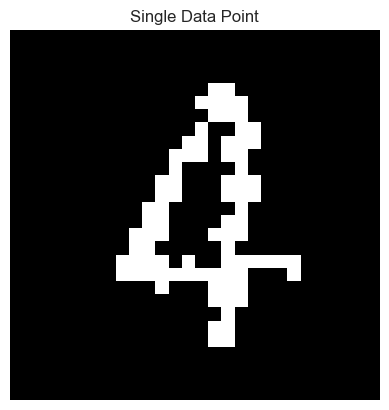

In [73]:
batch = next(train_dataloader)

# Take the first data point from the batch
data_point = batch['image'][0]
plt.imshow(data_point.squeeze(), cmap='gray')  # Use 'gray' for grayscale images
plt.title('Single Data Point')
plt.axis('off')
plt.show()

In [74]:
from model.encoder import ImageEncoder

key = jax.random.PRNGKey(0)
encoder = ImageEncoder(in_channels=1, out_channels=2, key=key)
encoder_fn = jax.vmap(encoder)


In [76]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

cpu


In [75]:
key = jax.random.PRNGKey(0)

model_key, key = jax.random.split(key)
model = ImageVAE(in_channels=1, n_latents=2, key=model_key)

optimizer = optax.adam(1e-3)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

pad_fn = jax.vmap(partial(jnp.pad, pad_width=2))


@eqx.filter_value_and_grad(has_aux=True)
def grad_and_loss(model: eqx.Module, batch: jnp.array, key: jax.random.PRNGKey):
    model_fn = jax.vmap(model)
    loss_fn = jax.vmap(get_evidence_lower_bound)
    keys = jax.random.split(key, BATCH_SIZE)
    model_output: ImageVAEOutput = model_fn(batch, key=keys)
    loss_output: ELBOLossOutput = loss_fn(batch, model_output)
    return jnp.mean(loss_output["loss"]), jax.tree_map(jnp.mean, loss_output)


@eqx.filter_jit
def make_step(
    model: eqx.Module,
    opt_state: PyTree,
    batch: jnp.array,
    *,
    key: jax.random.PRNGKey,
):
    (loss, aux), grads = grad_and_loss(model, batch, key)
    updates, update_opt_state = optimizer.update(grads, opt_state)
    update_model = eqx.apply_updates(model, updates)
    return (loss, aux), update_model, update_opt_state


step = 0
MAX_EPOCHS = 10
train_metrics = None
for epoch in range(MAX_EPOCHS):
    for batch in train_dataloader:
        batch = jnp.asarray(batch["image"]).astype(jnp.float32)
        batch = np.squeeze(batch)
        targets = pad_fn(batch)
        key, binarized_key = jax.random.split(key)
        targets = (
            dsx.Bernoulli(probs=targets).sample(seed=binarized_key).astype(jnp.float32)
        )
        key, step_key = jax.random.split(key)
        (loss, aux), model, opt_state = make_step(
            model, opt_state, targets, key=step_key
        )

        step += 1
        if step % 500 == 0:
            if train_metrics is None:
                train_metrics = {k: jnp.array([v]) for k, v in aux.items()}
                train_metrics["step"] = jnp.array([step])
            else:
                for k, v in aux.items():
                    train_metrics[k] = jnp.concatenate(
                        [train_metrics[k], jnp.array([v])]
                    )
                train_metrics["step"] = jnp.concatenate(
                    [train_metrics["step"], jnp.array([step])]
                )

            log_str = f"step/epoch: {step}/{epoch}"
            for k, v in aux.items():
                log_str += f"\t {k}: {v:.3f}"
            print(log_str)

visualize_reconstructions(model, targets)

K = len(train_metrics) - 1
plt.figure(figsize=(4 * K, 4))
for i, (k, v) in enumerate(train_metrics.items()):
    if k == "step":
        continue
    plt.subplot(1, K, i + 1)
    plt.title(k)
    plt.plot(train_metrics["step"], v)
    plt.xlabel("Optimization step")

KeyboardInterrupt: 

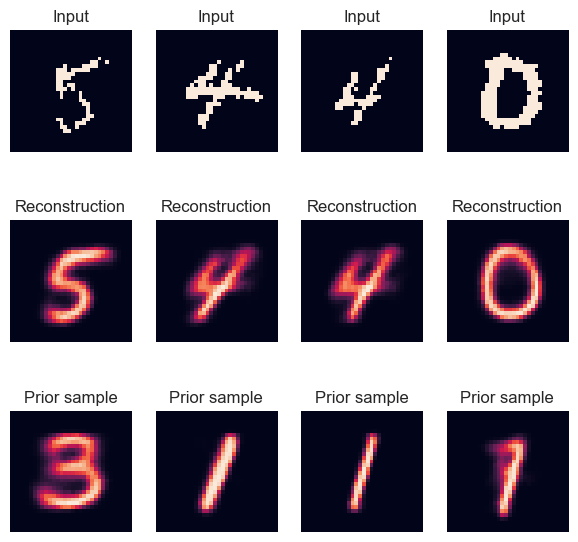

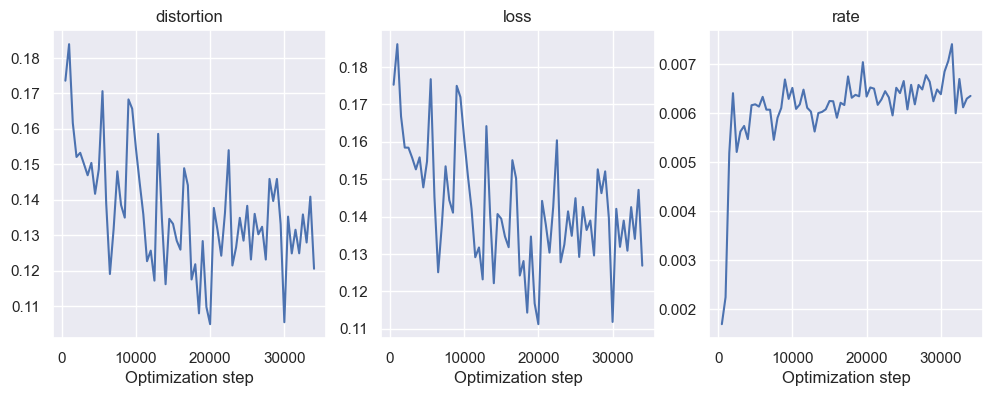

In [10]:
visualize_reconstructions(model, targets)

K = len(train_metrics) - 1
plt.figure(figsize=(4 * K, 4))
for i, (k, v) in enumerate(train_metrics.items()):
    if k == "step":
        continue
    plt.subplot(1, K, i + 1)
    plt.title(k)
    plt.plot(train_metrics["step"], v)
    plt.xlabel("Optimization step")

In [11]:
from acquiring.sample_image import sample_a_image, get_next,update_images, binary_cross_entropy

In [57]:
BATCH_SIZE = 128

train_dataloader = load_dataset(tfds.Split.TRAIN, BATCH_SIZE)

2023-11-20 00:12:39.711260: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [58]:
#Pre_Process:
Nz = 10
Nx = 5


sample_a_image_fn = jax.vmap(sample_a_image, in_axes=(None, None, 0, None, 0))
get_next_fn = jax.vmap(get_next)
update_images_fn = jax.vmap(update_images)


model_fn = jax.vmap(model)
keys = jax.random.split(key, BATCH_SIZE)

In [59]:
batch_test = next(train_dataloader)
batch_test['image'].shape

(128, 28, 28, 1)

In [60]:
original_images = np.squeeze(batch_test['image'])

original_images = original_images.astype(np.float32)
images_float = original_images
half_height = images_float.shape[1] // 2
images_with_top_half_missing = images_float.copy()
images_with_top_half_missing[:, :half_height, :] = np.nan
#Get mask
mask_missing = np.isnan(images_with_top_half_missing)
mask_observed = ~mask_missing
images_refill = update_images_fn(original_images,mask_observed)

#Shape
mask_observed = pad_fn(mask_observed)
images_refill = pad_fn(images_refill)
orginial_images = pad_fn(original_images)


In [61]:
#demo 
model_output: ImageVAEOutput = model(images_refill[0], key=key)

a = sample_a_image(Nz, Nx,model_output, model, key)
img, msk= get_next(a, mask_observed[0],images_refill[0],orginial_images[0])
#print(np.sum(msk))

In [62]:
def update(images: jnp.ndarray, mask_observed: jnp.ndarray, rng):
    batch_rng = jax.random.split(rng, BATCH_SIZE) 
    model_output: ImageVAEOutput = model_fn(images_refill, key=batch_rng)
    R = sample_a_image_fn(Nz, Nx,model_output,model, batch_rng)
    images_updated, mask_return = get_next_fn(R, mask_observed, images,orginial_images)
    return images_updated, mask_return

Step 0: Mean Log Likelihood = -687.5802001953125


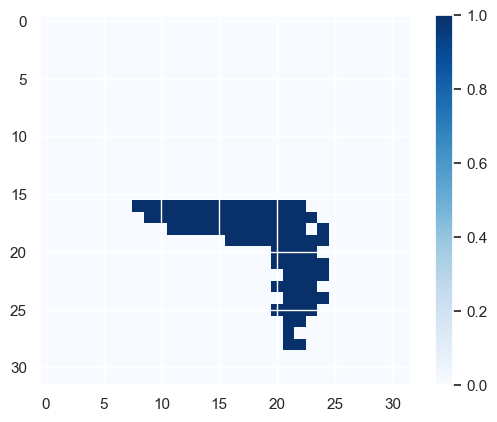

Step 10: Mean Log Likelihood = -685.8707275390625


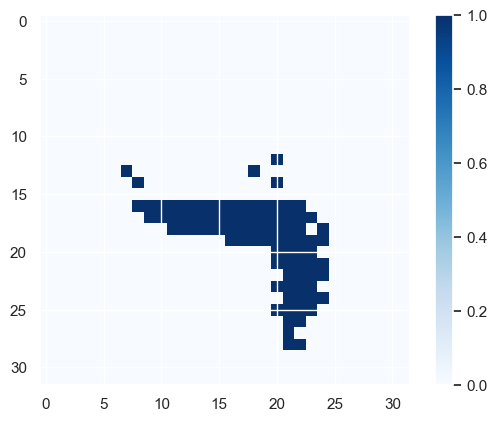

Step 20: Mean Log Likelihood = -684.3067016601562


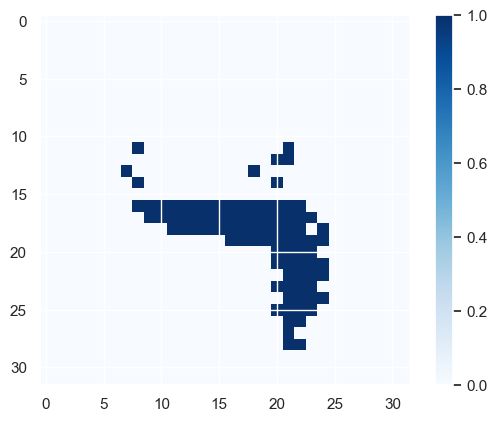

Step 30: Mean Log Likelihood = -682.5259399414062


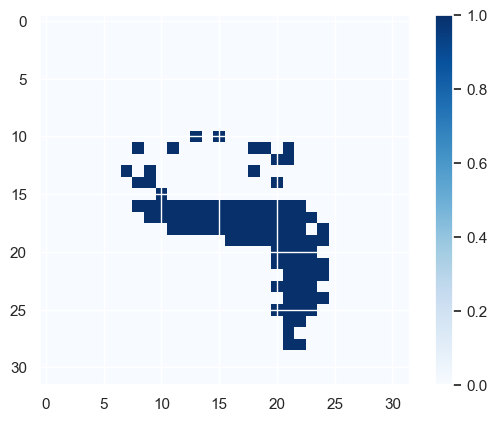

Step 40: Mean Log Likelihood = -680.9619140625


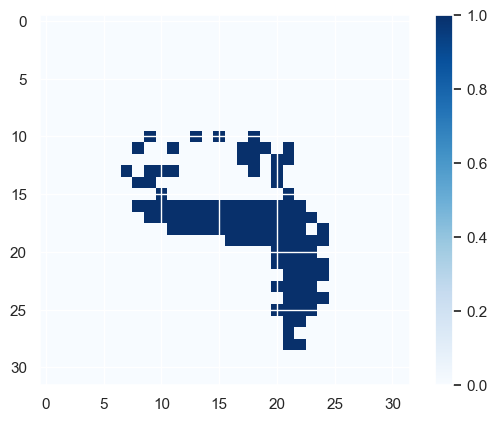

Step 50: Mean Log Likelihood = -679.4334716796875


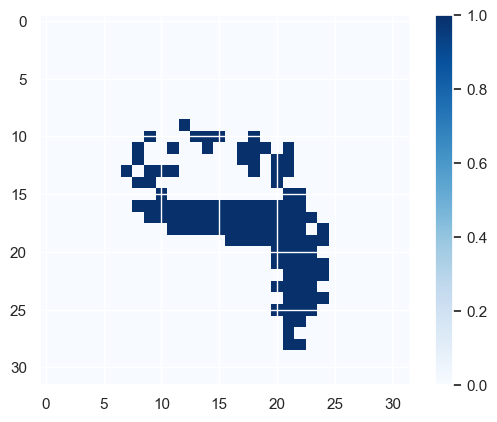

Step 60: Mean Log Likelihood = -678.1216430664062


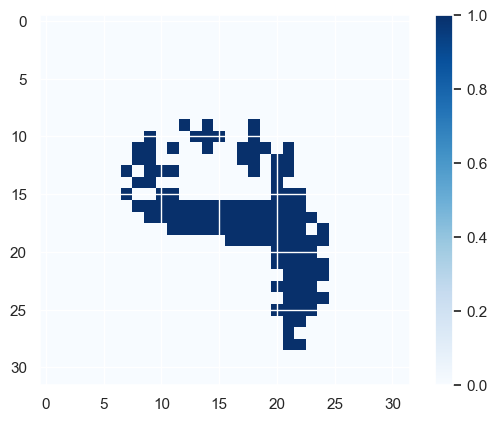

Step 70: Mean Log Likelihood = -676.8573608398438


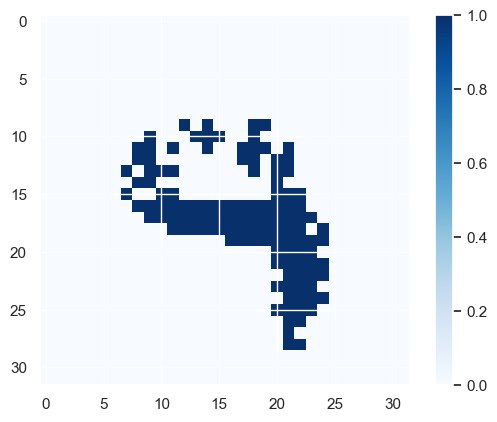

Step 80: Mean Log Likelihood = -675.60791015625


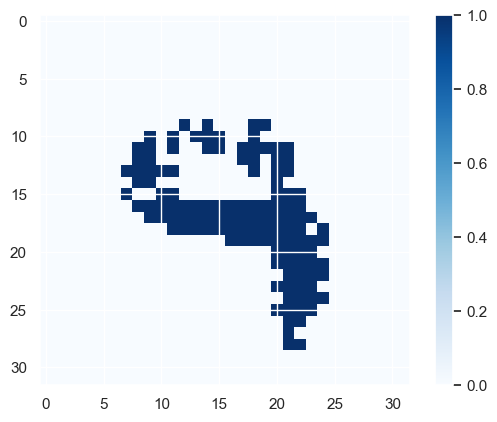

Step 90: Mean Log Likelihood = -674.5335083007812


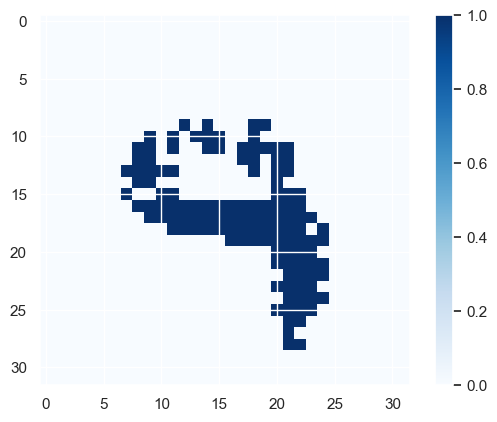

Step 100: Mean Log Likelihood = -673.5274658203125
Step 110: Mean Log Likelihood = -672.8092041015625
Step 120: Mean Log Likelihood = -672.23046875
Step 130: Mean Log Likelihood = -671.9603881835938
Step 140: Mean Log Likelihood = -671.871337890625
Step 150: Mean Log Likelihood = -671.829833984375
Step 160: Mean Log Likelihood = -671.8179321289062
Step 170: Mean Log Likelihood = -671.81201171875
Step 180: Mean Log Likelihood = -671.8090209960938
Step 190: Mean Log Likelihood = -671.8090209960938


In [63]:
inital_images = images_refill
initial_mask = mask_observed
current_images = inital_images
current_mask = initial_mask

steps = 10  # Calculate log likelihood every 100 steps
step_counter = 0
max_step = 200
recon_value = []
step_numbers = [] 
std = []
while np.any(~mask_observed) and step_counter< max_step:
    current_images, current_mask = update(current_images, current_mask, key)
    
    if step_counter % steps == 0:
        new_log_likelihood = -binary_cross_entropy(orginial_images, current_images)
        mean_log_likelihood = jnp.mean(new_log_likelihood)
        std_likelihood = jnp.std(new_log_likelihood)
        std.append(std_likelihood)
        recon_value.append(-mean_log_likelihood)
        step_numbers.append(step_counter)
        print(f"Step {step_counter}: Mean Log Likelihood = {mean_log_likelihood}")
    if step_counter % steps == 0 and step_counter < 100:
        plt.imshow(current_images[0], cmap='Blues', vmin=0, vmax=1)
        plt.colorbar()
        plt.show()
        
    step_counter += 1
    

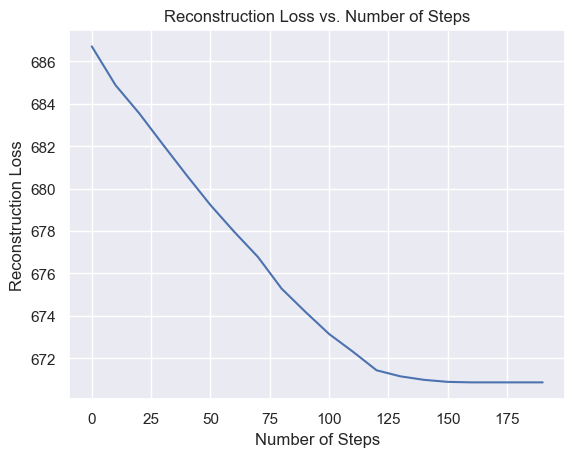

In [31]:
plt.plot(step_numbers, recon_value)  # Use step_numbers for the x-axis
plt.title('Reconstruction Loss vs. Number of Steps')
plt.xlabel('Number of Steps')
plt.ylabel('Reconstruction Loss')
plt.show()

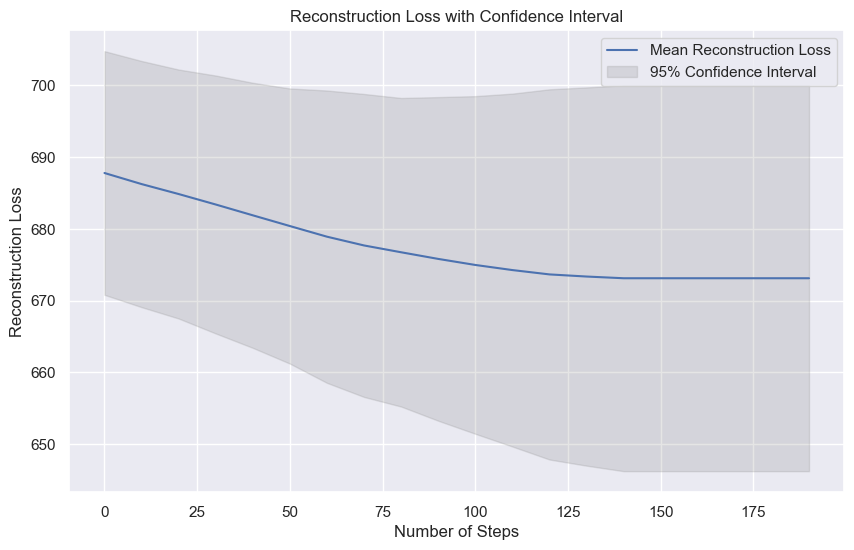

In [67]:
recon_value = np.array(recon_value)
std_deviation = np.array(std)

# Calculate the upper and lower bounds of the confidence interval
ci = 1.96 * std_deviation  # 95% confidence interval for a normal distribution
lower_bound = recon_value - ci
upper_bound = recon_value + ci

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(step_numbers, recon_value, label='Mean Reconstruction Loss')
plt.fill_between(step_numbers, lower_bound, upper_bound, color='gray', alpha=0.2, label='95% Confidence Interval')
plt.title('Reconstruction Loss with Confidence Interval')
plt.xlabel('Number of Steps')
plt.ylabel('Reconstruction Loss')
plt.legend()
plt.show()

In [32]:
from acquiring.sample_image import random_get_next
from jax import random

In [33]:
def random_update(images: jnp.ndarray, mask_observed: jnp.ndarray, rng):
    images_updated, mask_return = random_get_next(mask_observed, images, orginial_images, rng)
    return images_updated, mask_return

Step 0: Mean Log Likelihood = -686.7047119140625


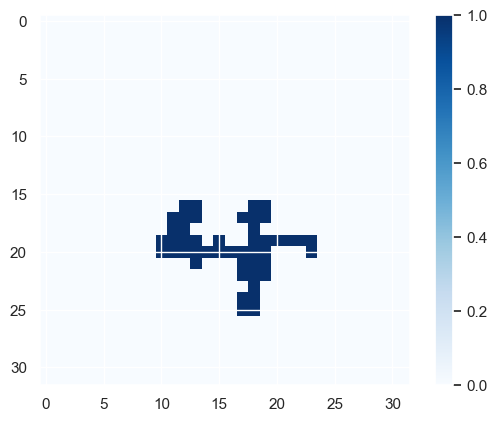

Step 10: Mean Log Likelihood = -686.3248291015625


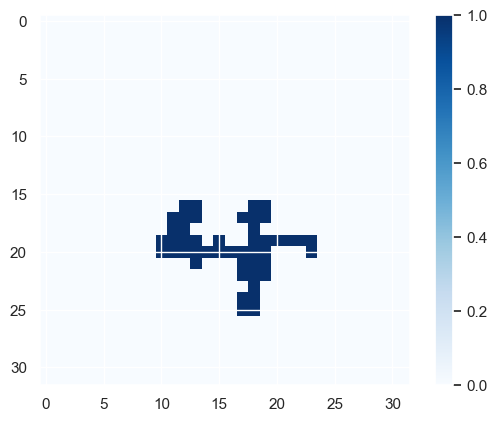

Step 20: Mean Log Likelihood = -685.70751953125


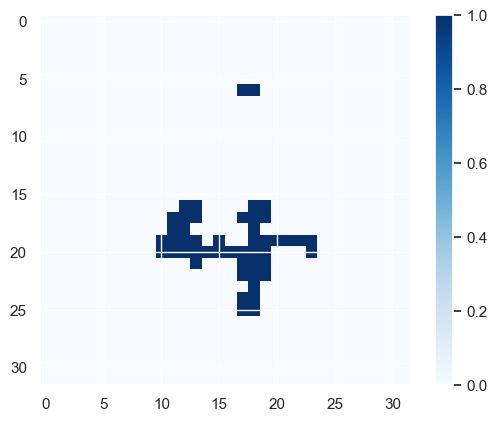

Step 30: Mean Log Likelihood = -685.161376953125


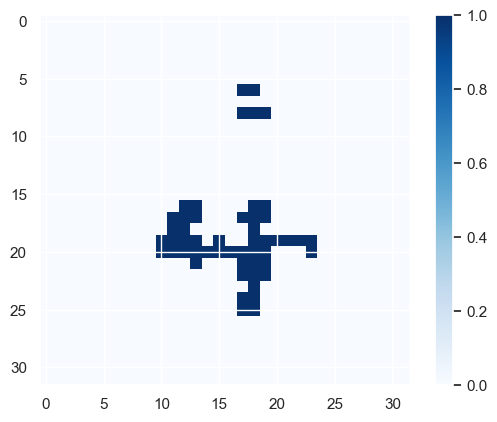

Step 40: Mean Log Likelihood = -684.211669921875


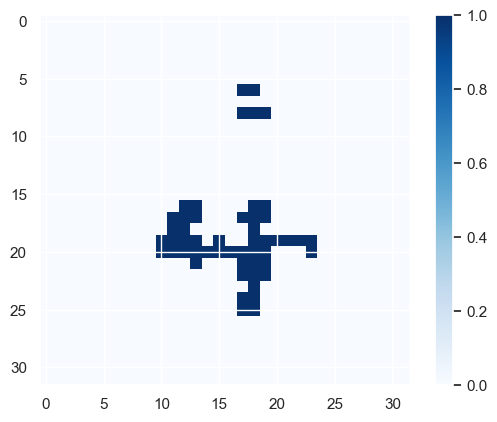

Step 50: Mean Log Likelihood = -683.546875


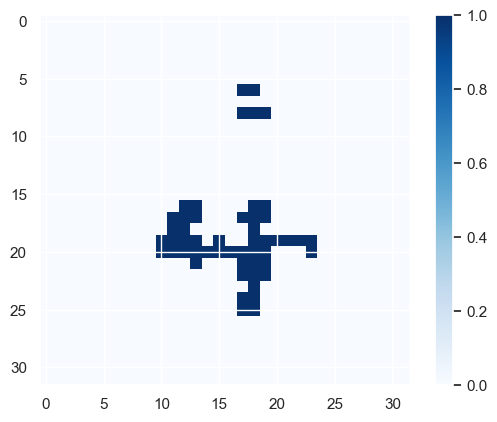

Step 60: Mean Log Likelihood = -682.97705078125


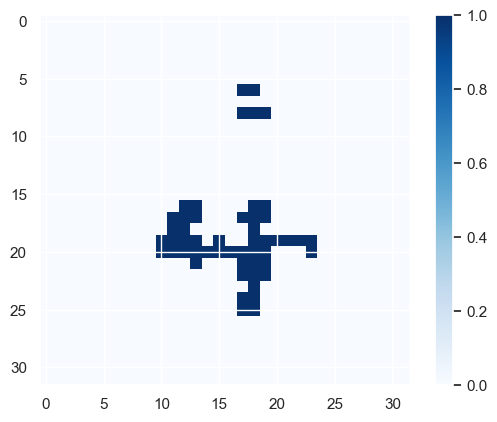

Step 70: Mean Log Likelihood = -682.3597412109375


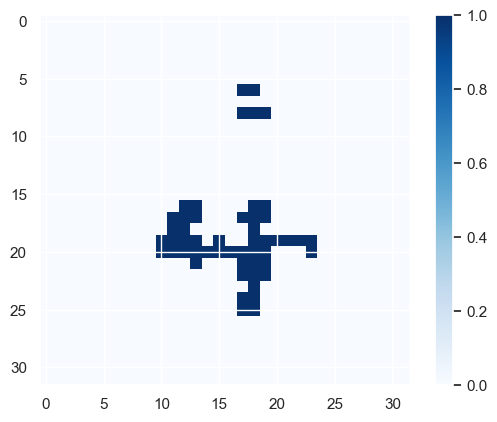

Step 80: Mean Log Likelihood = -681.1962890625


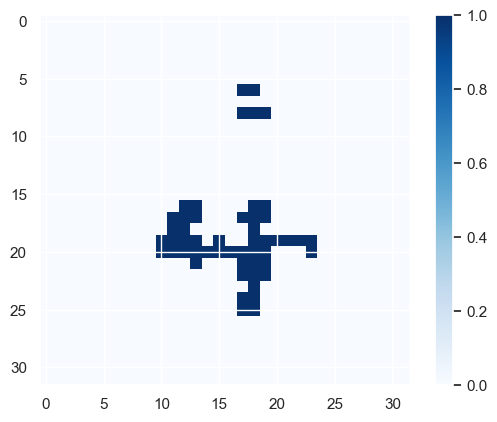

Step 90: Mean Log Likelihood = -680.792724609375


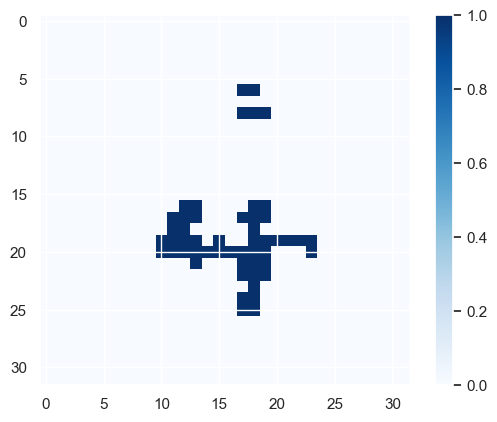

Step 100: Mean Log Likelihood = -680.5789794921875


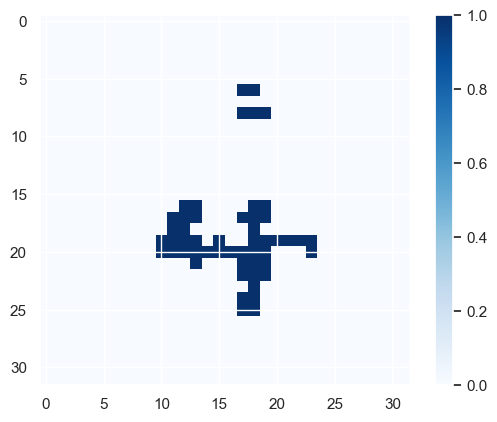

Step 110: Mean Log Likelihood = -679.961669921875


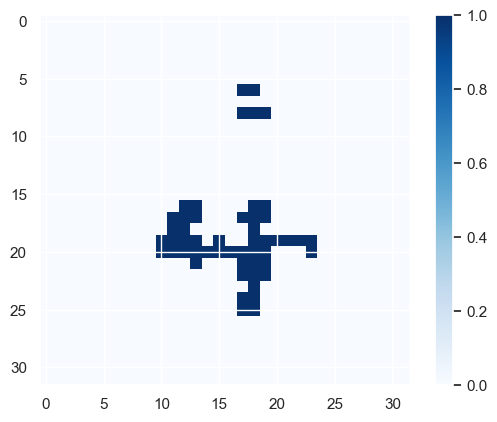

Step 120: Mean Log Likelihood = -678.72705078125


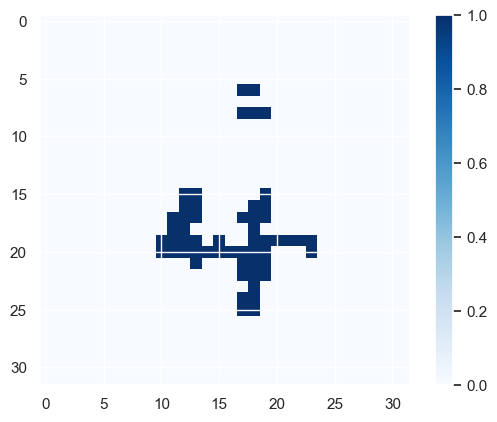

Step 130: Mean Log Likelihood = -678.1810302734375


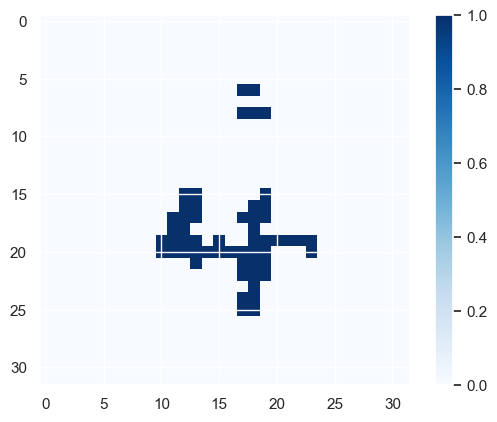

Step 140: Mean Log Likelihood = -677.4212646484375


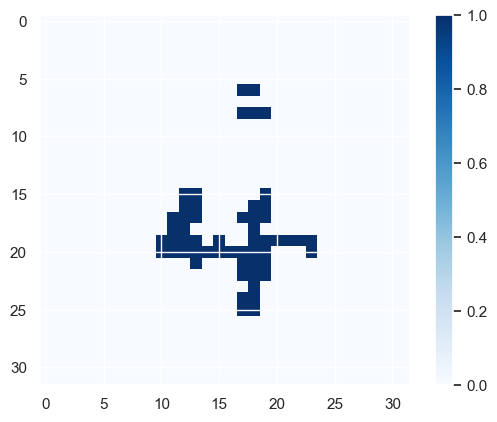

Step 150: Mean Log Likelihood = -676.8988647460938


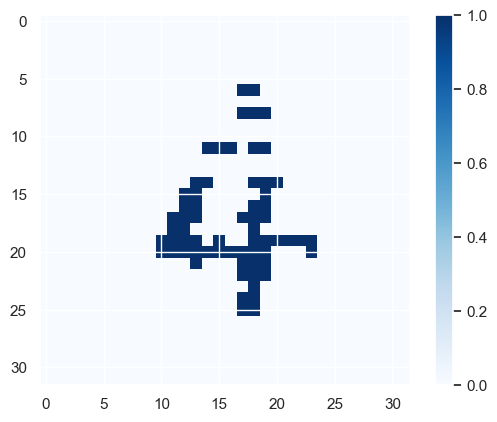

Step 160: Mean Log Likelihood = -676.542724609375


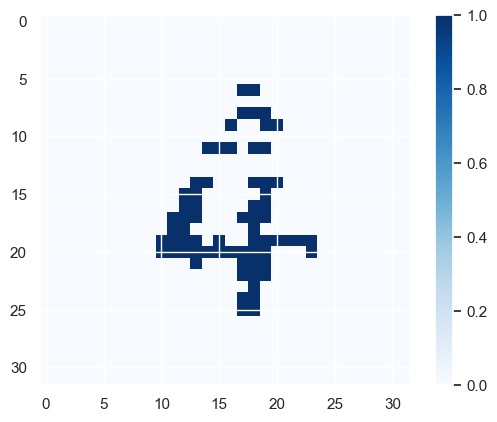

Step 170: Mean Log Likelihood = -676.1153564453125


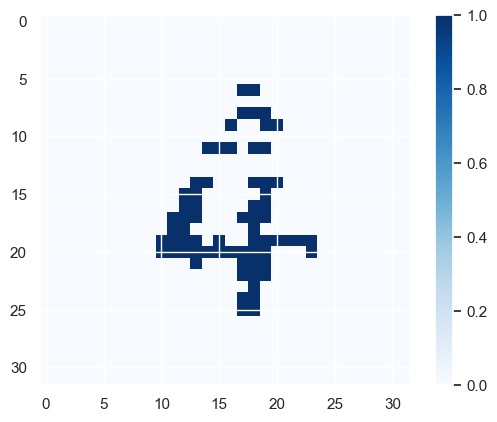

Step 180: Mean Log Likelihood = -675.5455322265625


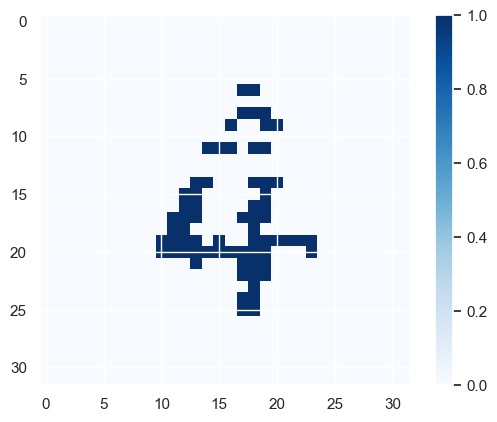

Step 190: Mean Log Likelihood = -674.9520263671875


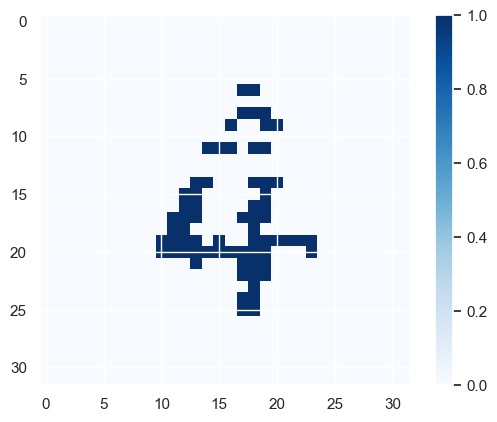

In [34]:
inital_images = images_refill
initial_mask = mask_observed
current_images = inital_images
current_mask = initial_mask

steps = 10  # Calculate log likelihood every 100 steps
step_counter = 0
max_step = 200
random_value = []
step_numbers = [] 
while np.any(~mask_observed) and step_counter< max_step:
    current_images, current_mask = random_update(current_images, current_mask, key)
    
    if step_counter % steps == 0:
        new_log_likelihood = -binary_cross_entropy(orginial_images, current_images)
        mean_log_likelihood = jnp.mean(new_log_likelihood)
        random_value.append(-mean_log_likelihood)
        step_numbers.append(step_counter)
        print(f"Step {step_counter}: Mean Log Likelihood = {mean_log_likelihood}")
    if step_counter % steps == 0 and step_counter < 100:
        plt.imshow(current_images[0], cmap='Blues', vmin=0, vmax=1)
        plt.colorbar()
        plt.show()
        
    step_counter += 1
    

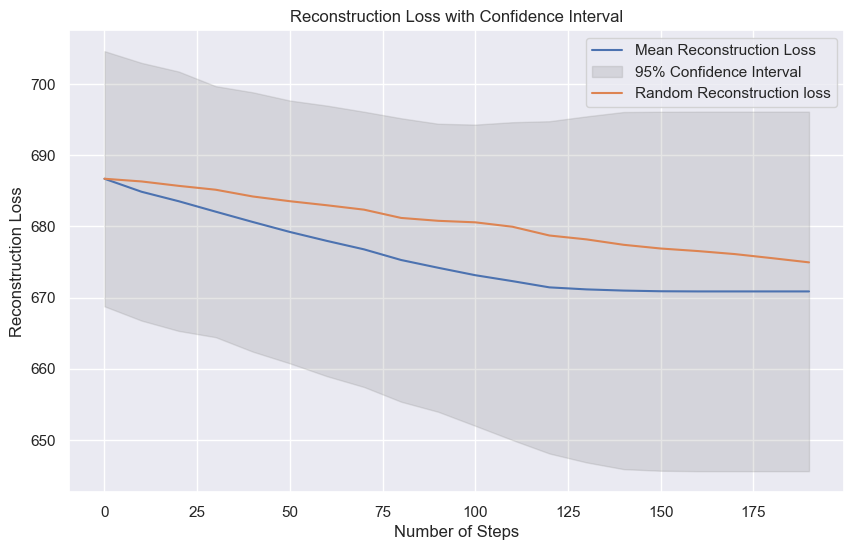

In [35]:
recon_value = np.array(recon_value)
std_deviation = np.array(std)

# Calculate the upper and lower bounds of the confidence interval
ci = 1.96 * std_deviation  # 95% confidence interval for a normal distribution
lower_bound = recon_value - ci
upper_bound = recon_value + ci

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(step_numbers, recon_value, label='Mean Reconstruction Loss')
plt.fill_between(step_numbers, lower_bound, upper_bound, color='gray', alpha=0.2, label='95% Confidence Interval')
plt.plot(step_numbers, random_value, label= "Random Reconstruction loss" )
plt.title('Reconstruction Loss with Confidence Interval')
plt.xlabel('Number of Steps')
plt.ylabel('Reconstruction Loss')
plt.legend()
plt.show()

In [56]:
batch_rng = jax.random.split(key, batch_size) 
model_output: ImageVAEOutput = model_fn(orginial_images, key=batch_rng)
reconstruction = model_output["observation_distribution"].sample(seed=key)
init_loss = -binary_cross_entropy(orginial_images, np.squeeze(reconstruction))
jnp.mean(init_loss)

Array(-714.7327, dtype=float32)